In [1]:
%load_ext autoreload
%autoreload 2

import fibsem
from fibsem import utils, acquire, movement, calibration
from fibsem.structures import BeamType
import numpy as np

from pprint import pprint
import os


In [2]:
protocol_path = r"C:\Users\Admin\Github\piescope_gui\mapping.yaml"
microscope, settings = utils.setup_session(protocol_path=protocol_path)

2022-09-27 16:26:12,293 — root — INFO — connect_to_microscope:28 — Microscope client connecting to [10.0.0.1]
2022-09-27 16:26:12,303 — root — INFO — connect_to_microscope:31 — Microscope client connected to [10.0.0.1]
2022-09-27 16:26:12,304 — root — INFO — setup_session:241 — Finished setup for session: mapping_2022-09-27.04-26-12PM


Client connecting to [10.0.0.1:7520]...
Client connected to [10.0.0.1:7520]


In [3]:
# settings.protocol
settings.image.save_path

'C:\\Users\\Admin\\Github\\piescope_gui\\mapping_2022-09-27.04-26-12PM'

In [4]:
# 11164.776
# 0.1, 350ms

In [5]:
def take_image_stack(microscope, settings, hfws, label):
    
    for hfw in hfws:
        settings.image.hfw = hfw
        settings.image.label = f"{label}_{hfw:.5f}"
    
        ib_image = acquire.new_image(microscope, settings.image)


def post_light_image_workflow(microscope, settings, state, hfws, diag_shift):
    
    diag_dx = np.sqrt(2) / 2  * diag_shift
    diag_dy = np.sqrt(2) / 2  * diag_shift
    
    # no move
    calibration.set_microscope_state(microscope, state)
    take_image_stack(microscope, settings, hfws, "base")

    # move diag down
    calibration.set_microscope_state(microscope, state)
    movement.move_stage_relative_with_corrected_movement(
        microscope, 
        settings,
        dx=-diag_dx,
        dy=-diag_dy,
        beam_type=BeamType.ION     
    )
    take_image_stack(microscope, settings, hfws, "diag_down")

    # move diag up 
    calibration.set_microscope_state(microscope, state)
    movement.move_stage_relative_with_corrected_movement(
        microscope, 
        settings,
        dx=diag_dx,
        dy=diag_dy,
        beam_type=BeamType.ION     
    )
    take_image_stack(microscope, settings, hfws, "diag_up")



In [6]:
log_path = settings.image.save_path
settings.image.beam_type = BeamType.ION
settings.image.dwell_time = 1e-6
settings.image.save = True
settings.image.resolution = "1536x1024"
# settings.image.save_path = log_path
hfws = [80e-6, 150e-6, 200e-6, 300e-6, 500e-6]

tile_shift = 80e-6
diag_shift = 80e-6


In [7]:
settings.image.save_path


'C:\\Users\\Admin\\Github\\piescope_gui\\mapping_2022-09-27.04-26-12PM'

In [8]:
# initial position
initial_position = calibration.get_current_microscope_state(microscope)

2022-09-27 13:34:35,197 — root — INFO — move_stage_relative_with_corrected_movement:450 — moving stage: StagePosition(x=0, y=-7.1280522e-05, z=3.631924e-05)


In [9]:
N_GRID_Y = 2
N_GRID_X = 2


# TODO: save coordinates

for grid_y in range(N_GRID_Y):
    for grid_x in range(N_GRID_X):

        # set folder for grid step
        settings.image.save_path = os.path.join(log_path, f"{grid_y:03}.{grid_x:03}")

        # take base images and state
        base_state = calibration.get_current_microscope_state(microscope)
        take_image_stack(microscope, settings, hfws, "start")

        # move to piescope, take light image

        # paause for piescope workflow
        input("PIESCOPE WORKFLOW")

        # post piescope workflow
        post_light_image_workflow(microscope, settings, base_state, hfws, diag_shift)

        # move stage to next tile column
        calibration.set_microscope_state(microscope, base_state)
        acquire.new_image(microscope, settings.image)
        movement.move_stage_relative_with_corrected_movement(
            microscope, settings, dx=tile_shift, dy=0, beam_type=BeamType.ION 
        )

    # move back to initial grid position
    calibration.set_microscope_state(microscope, initial_position)

    # move to next grid row
    movement.move_stage_relative_with_corrected_movement(
        microscope, settings, dx=0, dy=-tile_shift, beam_type=BeamType.ION 
    )
    initial_position = calibration.get_current_microscope_state(microscope)

2022-09-27 16:26:40,367 — root — INFO — autocontrast:27 — automatically adjusting contrast...
2022-09-27 16:26:40,687 — root — INFO — acquire_image:187 — acquiring new ION image.
2022-09-27 16:26:42,537 — root — INFO — gamma_correction:86 — GAMMA_CORRECTION | Ion | -54.336 | 0.457
2022-09-27 16:26:42,591 — root — INFO — autocontrast:27 — automatically adjusting contrast...
2022-09-27 16:26:43,022 — root — INFO — acquire_image:187 — acquiring new ION image.
2022-09-27 16:26:44,863 — root — INFO — gamma_correction:86 — GAMMA_CORRECTION | Ion | -58.798 | 0.412
2022-09-27 16:26:44,903 — root — INFO — autocontrast:27 — automatically adjusting contrast...
2022-09-27 16:26:45,232 — root — INFO — acquire_image:187 — acquiring new ION image.
2022-09-27 16:26:47,072 — root — INFO — gamma_correction:86 — GAMMA_CORRECTION | Ion | -60.228 | 0.398
2022-09-27 16:26:47,111 — root — INFO — autocontrast:27 — automatically adjusting contrast...
2022-09-27 16:26:47,421 — root — INFO — acquire_image:187 — 

In [2]:
import pandas as pd

df = pd.DataFrame(columns=["fname", "hfw", "x", "y", "z", "r", "t"])
print(df)

Empty DataFrame
Columns: [fname, x, y, z, r, t]
Index: []


2022-09-27 14:00:42,044 — root — INFO — autocontrast:27 — automatically adjusting contrast...
2022-09-27 14:00:42,580 — root — INFO — acquire_image:187 — acquiring new ION image.
2022-09-27 14:00:44,448 — root — INFO — gamma_correction:86 — GAMMA_CORRECTION | Ion | -103.873 | 0.150


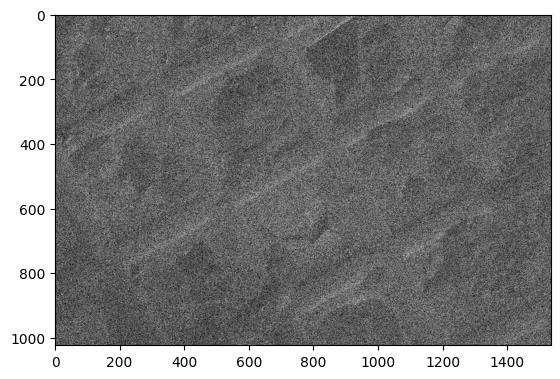

In [38]:
settings.image.dwell_time = 1e-6
settings.image.save = True
# settings.image.save_path = r"C:\Users\Admin\Github\piescope_gui\mapping_2022-09-27.01-59-14PM"
settings.image.label = "500"
settings.image.beam_type = BeamType.ION
settings.image.hfw = 500e-6


img = acquire.new_image(microscope, settings.image)
import skimage
import matplotlib.pyplot as plt
plt.imshow(img.data, cmap="gray")
plt.show()

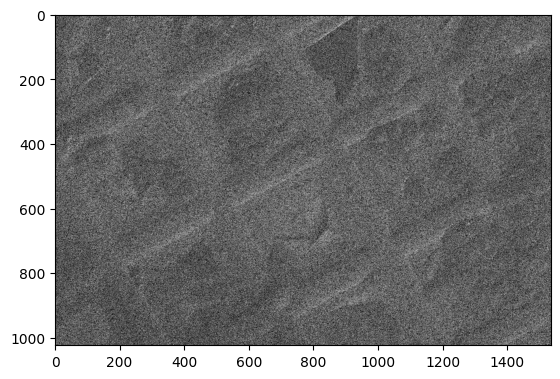

In [87]:
grid_y = 0
grid_x = 1
settings.image.save_path = os.path.join("correlation", f"{grid_y:03}.{grid_x:03}")

In [88]:
print(settings.image.save_path)

correlation\000.001


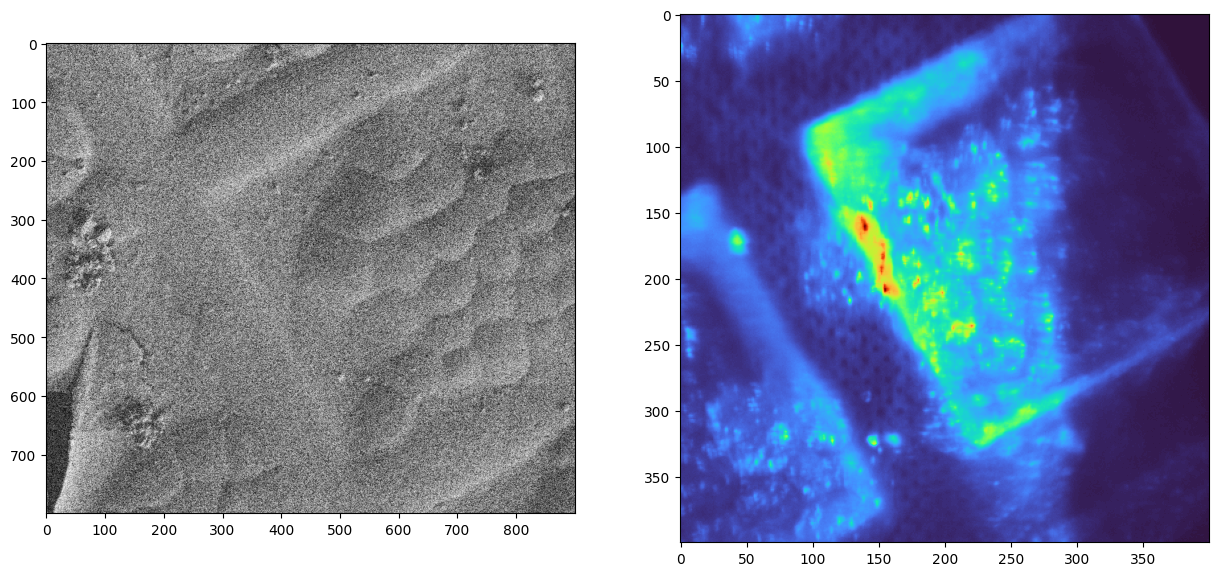

In [57]:
fl_path =r"C:\Users\Admin\Github\piescope_gui\mapping_2022-09-27.02-59-50PM\fluro/2.2.350_2022-09-27T154612586247.tiff"
ib_path = r"C:\Users\Admin\Github\piescope_gui\mapping_2022-09-27.02-59-50PM\002.002/base_0.00030_ib.tif"

import matplotlib.pyplot as plt
import tifffile as tf

ib_image = tf.imread(ib_path)[:800, :900]
fl_image = tf.imread(fl_path)[900:1300, 800:1200].T

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(ib_image, cmap="gray")
ax[1].imshow(fl_image, cmap="turbo")
plt.show()



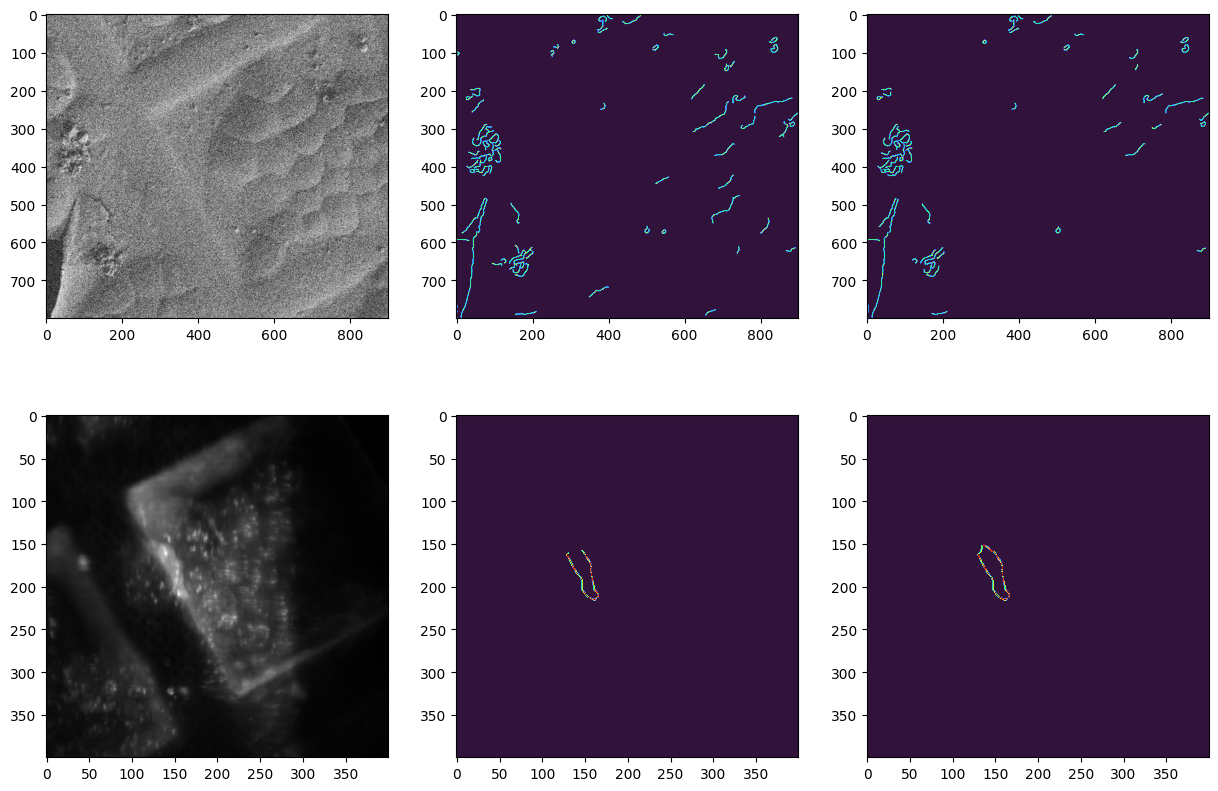

In [56]:
from fibsem.detection import detection

import scipy.ndimage as ndi
filt_ib = ndi.gaussian_filter(ib_image, sigma=1)
filt_fl = ndi.gaussian_filter(fl_image, sigma=1)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0][0].imshow(ib_image, cmap="gray")
ax[0][1].imshow(detection.edge_detection(ib_image, sigma=3), alpha=1, cmap="turbo")
ax[0][2].imshow(detection.edge_detection(filt_ib, sigma=3), alpha=1, cmap="turbo")
ax[1][0].imshow(fl_image, cmap="gray")
ax[1][1].imshow(detection.edge_detection(fl_image, sigma=3), alpha=1, cmap="turbo")
ax[1][2].imshow(detection.edge_detection(filt_fl, sigma=3), alpha=1, cmap="turbo")
plt.show()